In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install segmentation_models_pytorch

      Successfully uninstalled nvidia-cublas-cu12-12.5.3.2
  Attempting uninstall: nvidia-cusparse-cu12
    Found existing installation: nvidia-cusparse-cu12 12.5.1.3
    Uninstalling nvidia-cusparse-cu12-12.5.1.3:
      Successfully uninstalled nvidia-cusparse-cu12-12.5.1.3
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.3.0.75
    Uninstalling nvidia-cudnn-cu12-9.3.0.75:
      Successfully uninstalled nvidia-cudnn-cu12-9.3.0.75
  Attempting uninstall: nvidia-cusolver-cu12
    Found existing installation: nvidia-cusolver-cu12 11.6.3.83
    Uninstalling nvidia-cusolver-cu12-11.6.3.83:
      Successfully uninstalled nvidia-cusolver-cu12-11.6.3.83


In [24]:
import os
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from segmentation_models_pytorch import Unet
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 8
LR = 1e-4
EPOCHS = 20
IMG_SIZE = 256
DATASET_PATH = '/content/drive/MyDrive/DRIVE/DRIVE/train'

In [17]:
class RetinaDataset(Dataset):
    def __init__(self, image_paths, mask_paths, fov_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.fov_paths = fov_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask_path = self.mask_paths[idx]
        if mask_path.endswith('.gif'):
            gif = Image.open(mask_path)
            mask = np.array(gif.convert('L'))
        else:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise FileNotFoundError(f"Mask not found: {mask_path}")
        mask = (mask > 127).astype(np.float32)

        fov_path = self.fov_paths[idx]
        if fov_path.endswith('.gif'):
            gif = Image.open(fov_path)
            fov_mask = np.array(gif.convert('L'))
        else:
            fov_mask = cv2.imread(fov_path, cv2.IMREAD_GRAYSCALE)
            if fov_mask is None:
                raise FileNotFoundError(f"FOV mask not found: {fov_path}")
        fov_mask = (fov_mask > 127).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        fov_mask = torch.tensor(fov_mask, dtype=torch.float32).unsqueeze(0)
        return image, mask.unsqueeze(0), fov_mask

transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

<ipython-input-17-50ca90f69cbc>:44: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(IMG_SIZE, IMG_SIZE, always_apply=True),


In [6]:
image_paths = [os.path.join(DATASET_PATH, 'images', f) for f in os.listdir(os.path.join(DATASET_PATH, 'images'))]
mask_paths = [os.path.join(DATASET_PATH, '1st_manual', f) for f in os.listdir(os.path.join(DATASET_PATH, '1st_manual'))]
fov_paths = [os.path.join(DATASET_PATH, 'mask', f) for f in os.listdir(os.path.join(DATASET_PATH, 'mask'))]

dataset = RetinaDataset(image_paths, mask_paths, fov_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=1).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 84.7MB/s]


In [7]:
def masked_loss(pred, target, fov_mask, criterion):
    loss = criterion(pred, target)
    masked_loss = loss * fov_mask
    return masked_loss.mean()

In [8]:
def train(model, dataloader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for images, masks, fov_masks in dataloader:
            images, masks, fov_masks = images.to(DEVICE), masks.to(DEVICE), fov_masks.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = masked_loss(outputs, masks, fov_masks, criterion)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader):.4f}")

train(model, dataloader, optimizer, criterion, EPOCHS)

torch.save(model.state_dict(), 'unet_retina.pth')

Epoch [1/20], Loss: 0.6744
Epoch [2/20], Loss: 0.6198
Epoch [3/20], Loss: 0.5672
Epoch [4/20], Loss: 0.5304
Epoch [5/20], Loss: 0.4971
Epoch [6/20], Loss: 0.4734
Epoch [7/20], Loss: 0.4403
Epoch [8/20], Loss: 0.4471
Epoch [9/20], Loss: 0.4132
Epoch [10/20], Loss: 0.4077
Epoch [11/20], Loss: 0.3967
Epoch [12/20], Loss: 0.3814
Epoch [13/20], Loss: 0.3675
Epoch [14/20], Loss: 0.3597
Epoch [15/20], Loss: 0.3483
Epoch [16/20], Loss: 0.3468
Epoch [17/20], Loss: 0.3341
Epoch [18/20], Loss: 0.3298
Epoch [19/20], Loss: 0.3252
Epoch [20/20], Loss: 0.3187


In [10]:
def masked_iou(pred, target, fov_mask, threshold=0.5):
    pred_bin = (torch.sigmoid(pred) > threshold).float()
    target = target.float()
    fov_mask = fov_mask.float()

    target = F.interpolate(target, size=pred_bin.shape[-2:], mode='nearest')
    fov_mask = F.interpolate(fov_mask, size=pred_bin.shape[-2:], mode='nearest')

    intersection = (pred_bin * target * fov_mask).sum()
    union = ((pred_bin + target) * fov_mask).sum()
    return intersection / (union + 1e-6)

def masked_dice(pred, target, fov_mask, threshold=0.5):
    pred_bin = (torch.sigmoid(pred) > threshold).float()
    target = target.float()
    fov_mask = fov_mask.float()

    target = F.interpolate(target, size=pred_bin.shape[-2:], mode='nearest')
    fov_mask = F.interpolate(fov_mask, size=pred_bin.shape[-2:], mode='nearest')

    intersection = (pred_bin * target * fov_mask).sum()
    dice = (2. * intersection) / ((pred_bin + target).sum() + 1e-6)
    return dice

def evaluate(model, dataloader):
    model.eval()
    total_iou = 0
    total_dice = 0
    with torch.no_grad():
        for images, masks, fov_masks in dataloader:
            images, masks, fov_masks = images.to(DEVICE), masks.to(DEVICE), fov_masks.to(DEVICE)
            outputs = model(images)
            iou = masked_iou(outputs, masks, fov_masks)
            dice = masked_dice(outputs, masks, fov_masks)
            total_iou += iou.item()
            total_dice += dice.item()
    print(f"Mean IoU: {total_iou / len(dataloader):.4f}")
    print(f"Mean Dice: {total_dice / len(dataloader):.4f}")

In [11]:
evaluate(model, dataloader)

Mean IoU: 0.0474
Mean Dice: 0.0911


In [12]:
standard_model = torch.hub.load("mateuszbuda/brain-segmentation-pytorch", "unet",
                                in_channels=3, out_channels=1, init_features=32, pretrained=True)
standard_model.to(DEVICE)
standard_model.eval()

def preprocess_image(image_path, img_size=256):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (img_size, img_size))

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = transform(image).unsqueeze(0)
    return image.to(DEVICE)

def predict_mask(image_path, model):
    image = preprocess_image(image_path)
    with torch.no_grad():
        output = model(image)
        predicted_mask = torch.sigmoid(output)
        predicted_mask = (predicted_mask > 0.5).float()
    return predicted_mask.squeeze().cpu().numpy()

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


In [13]:
def masked_iou(pred, target, fov_mask, threshold=0.5):
    pred_bin = (torch.sigmoid(pred) > threshold).float()
    target = target.float()
    fov_mask = fov_mask.float()

    target = F.interpolate(target, size=pred_bin.shape[-2:], mode='nearest')
    fov_mask = F.interpolate(fov_mask, size=pred_bin.shape[-2:], mode='nearest')

    intersection = (pred_bin * target * fov_mask).sum()
    union = ((pred_bin + target) * fov_mask).sum()
    return intersection / (union + 1e-6)

def masked_dice(pred, target, fov_mask, threshold=0.5):
    pred_bin = (torch.sigmoid(pred) > threshold).float()
    target = target.float()
    fov_mask = fov_mask.float()

    target = F.interpolate(target, size=pred_bin.shape[-2:], mode='nearest')
    fov_mask = F.interpolate(fov_mask, size=pred_bin.shape[-2:], mode='nearest')

    intersection = (pred_bin * target * fov_mask).sum()
    dice = (2. * intersection) / ((pred_bin + target).sum() + 1e-6)
    return dice

def compare_models(custom_model, standard_model, dataloader, num_samples=3):
    custom_model.eval()
    standard_model.eval()

    total_iou_custom, total_dice_custom = 0, 0
    total_iou_standard, total_dice_standard = 0, 0

    count = 0
    total_images = 0

    for images, masks, fov_masks in dataloader:
        images, masks, fov_masks = images.to(DEVICE), masks.to(DEVICE), fov_masks.to(DEVICE)

        with torch.no_grad():
            custom_preds = custom_model(images)
            standard_preds = standard_model(images)

        batch_size = images.size(0)
        for i in range(batch_size):
            iou_c = masked_iou(custom_preds[i:i+1], masks[i:i+1], fov_masks[i:i+1])
            dice_c = masked_dice(custom_preds[i:i+1], masks[i:i+1], fov_masks[i:i+1])

            iou_s = masked_iou(standard_preds[i:i+1], masks[i:i+1], fov_masks[i:i+1])
            dice_s = masked_dice(standard_preds[i:i+1], masks[i:i+1], fov_masks[i:i+1])

            total_iou_custom += iou_c.item()
            total_dice_custom += dice_c.item()
            total_iou_standard += iou_s.item()
            total_dice_standard += dice_s.item()

            if count < num_samples:
                visualize_comparison(images[i], masks[i], custom_preds[i], standard_preds[i], count)
                save_overlay(images[i], custom_preds[i], filename=f"overlay_custom_{count}.png")
                save_overlay(images[i], standard_preds[i], filename=f"overlay_standard_{count}.png")
            count += 1
            total_images += 1

    print(f"\n--- Custom U-Net ---")
    print(f"Mean IoU:  {total_iou_custom / total_images:.4f}")
    print(f"Mean Dice: {total_dice_custom / total_images:.4f}")

    print(f"\n--- Standard U-Net ---")
    print(f"Mean IoU:  {total_iou_standard / total_images:.4f}")
    print(f"Mean Dice: {total_dice_standard / total_images:.4f}")

def visualize_comparison(image_tensor, gt_mask, pred_custom, pred_standard, idx):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    image = (image * 0.5 + 0.5) * 255
    image = image.astype(np.uint8)

    gt_mask = gt_mask.squeeze().cpu().numpy()
    pred_custom = torch.sigmoid(pred_custom).squeeze().cpu().numpy()
    pred_standard = torch.sigmoid(pred_standard).squeeze().cpu().numpy()

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(image)
    axs[0].set_title("Original")
    axs[1].imshow(gt_mask, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_custom > 0.5, cmap='gray')
    axs[2].set_title("Custom U-Net")
    axs[3].imshow(pred_standard > 0.5, cmap='gray')
    axs[3].set_title("Standard U-Net")

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"comparison_{idx}.png")
    plt.show()

def save_overlay(image_tensor, pred_mask, filename="overlay.png", alpha=0.5):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    image = (image * 0.5 + 0.5) * 255
    image = image.astype(np.uint8)

    pred_mask = torch.sigmoid(pred_mask).squeeze().cpu().numpy()
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8) * 255
    mask_rgb = cv2.applyColorMap(pred_mask_bin, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image, 1 - alpha, mask_rgb, alpha, 0)
    cv2.imwrite(filename, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

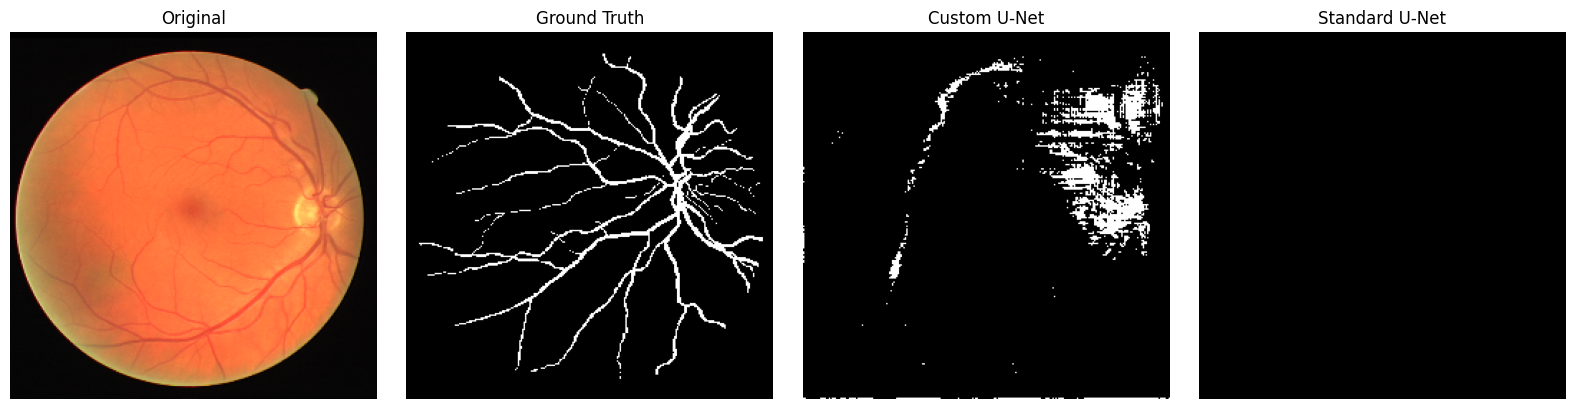

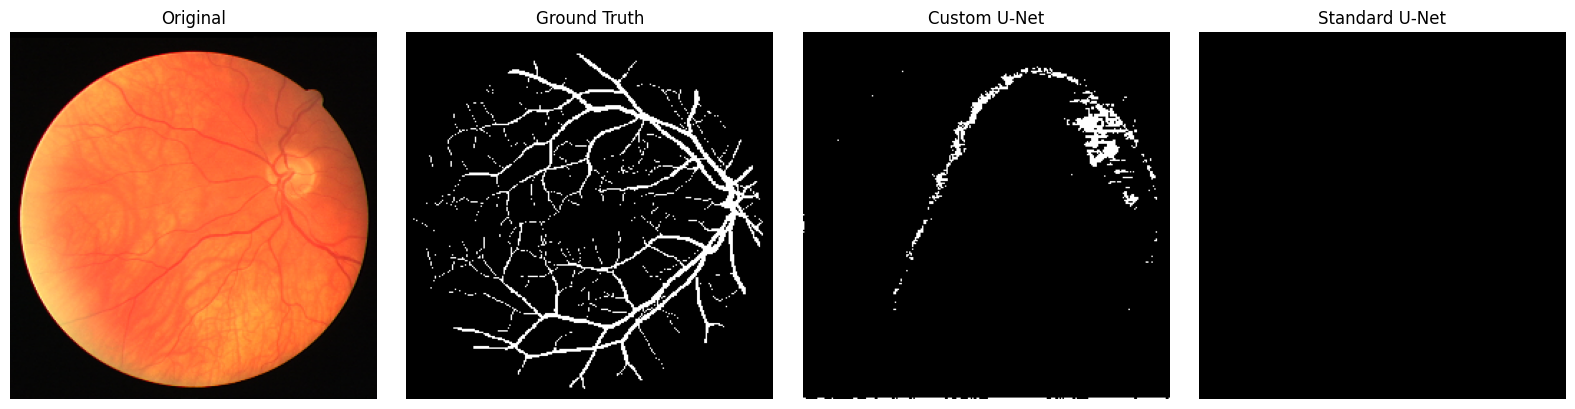

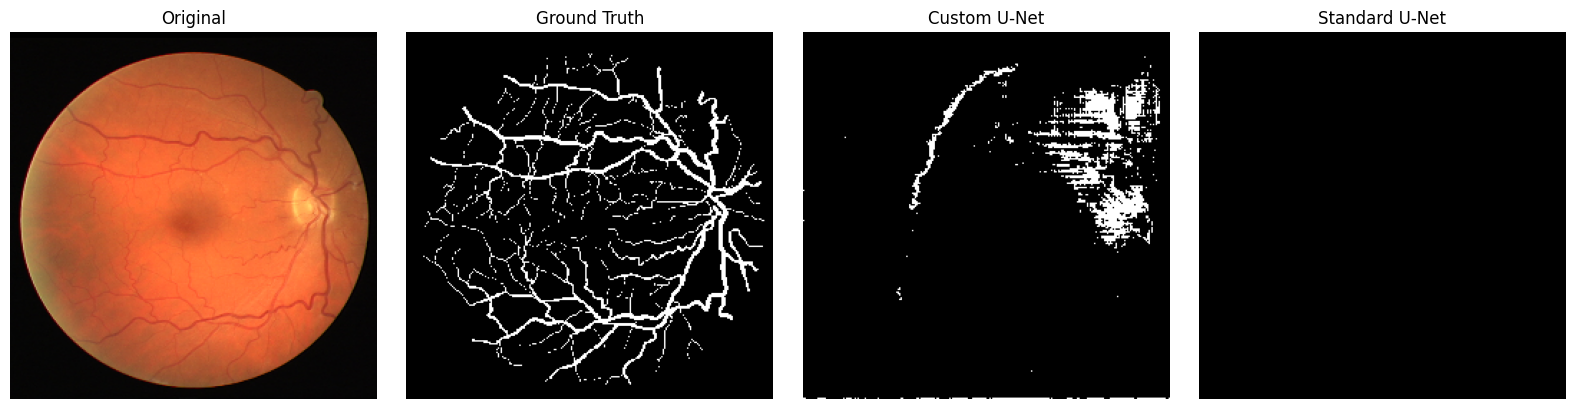


--- Custom U-Net ---
Mean IoU:  0.0485
Mean Dice: 0.0931

--- Standard U-Net ---
Mean IoU:  0.1108
Mean Dice: 0.1580


In [16]:
compare_models(model, standard_model, dataloader, num_samples=3)

sample_image, _, _ = dataset[0]
sample_image = sample_image.unsqueeze(0).to(DEVICE)
with torch.no_grad():
    sample_pred = model(sample_image)
save_overlay(sample_image[0], sample_pred[0], filename="retina_overlay.png")

In [30]:
def train_with_validation(model, train_dataloader, val_dataloader, optimizer, criterion, epochs, DEVICE):
    train_losses = []
    val_losses = []

    scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.2)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, masks, fov_masks in train_dataloader:
            images, masks, fov_masks = images.to(DEVICE), masks.to(DEVICE), fov_masks.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = masked_loss(outputs, masks, fov_masks, criterion)  #custom loss function for FOV mask
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_dataloader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks, fov_masks in val_dataloader:
                images, masks, fov_masks = images.to(DEVICE), masks.to(DEVICE), fov_masks.to(DEVICE)
                outputs = model(images)
                loss = masked_loss(outputs, masks, fov_masks, criterion)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_dataloader))

        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss / len(train_dataloader):.4f}, Validation Loss: {val_loss / len(val_dataloader):.4f}")

        scheduler.step()

    plt.figure(figsize=(8, 6))
    plt.plot(range(epochs), train_losses, label="Training Loss")
    plt.plot(range(epochs), val_losses, label="Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

from albumentations import Compose, Resize, Normalize, RandomCrop, HorizontalFlip
from albumentations.pytorch import ToTensorV2

transform = Compose([
    Resize(IMG_SIZE, IMG_SIZE),
    HorizontalFlip(p=0.5),
    RandomCrop(width=224, height=224, p=0.5),
    Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

class ModifiedUNet(nn.Module):
    def __init__(self):
        super(ModifiedUNet, self).__init__()
        self.unet = Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.unet(x)
        x = self.dropout(x)
        return x

model = ModifiedUNet().to(DEVICE)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Epoch [1/20], Training Loss: 0.4969, Validation Loss: 0.4189
Epoch [2/20], Training Loss: 0.4296, Validation Loss: 0.4091
Epoch [3/20], Training Loss: 0.3849, Validation Loss: 0.3501
Epoch [4/20], Training Loss: 0.3662, Validation Loss: 0.3697
Epoch [5/20], Training Loss: 0.3635, Validation Loss: 0.3556
Epoch [6/20], Training Loss: 0.3611, Validation Loss: 0.3456
Epoch [7/20], Training Loss: 0.3597, Validation Loss: 0.3407
Epoch [8/20], Training Loss: 0.3595, Validation Loss: 0.3374
Epoch [9/20], Training Loss: 0.3594, Validation Loss: 0.3340
Epoch [10/20], Training Loss: 0.3590, Validation Loss: 0.3312
Epoch [11/20], Training Loss: 0.3589, Validation Loss: 0.3291
Epoch [12/20], Training Loss: 0.3588, Validation Loss: 0.3275
Epoch [13/20], Training Loss: 0.3587, Validation Loss: 0.3260
Epoch [14/20], Training Loss: 0.3589, Validation Loss: 0.3247
Epoch [15/20], Training Loss: 0.3591, Validation Loss: 0.3235
Epoch [16/20], Training Loss: 0.3588, Validation Loss: 0.3226
Epoch [17/20], Tr

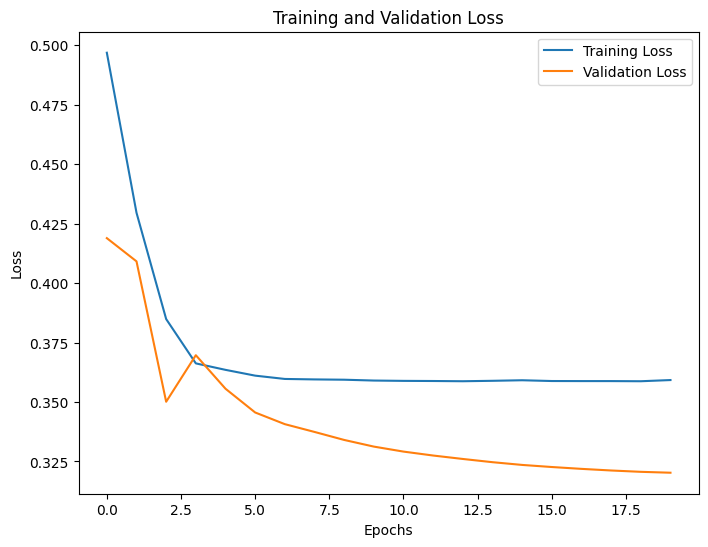

In [28]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_with_validation(model, train_dataloader, val_dataloader, optimizer, criterion, EPOCHS, DEVICE)

Epoch [1/20], Training Loss: 0.4427, Validation Loss: 0.3279
Epoch [2/20], Training Loss: 0.3867, Validation Loss: 0.3534
Epoch [3/20], Training Loss: 0.3555, Validation Loss: 0.3321
Epoch [4/20], Training Loss: 0.3439, Validation Loss: 0.3442
Epoch [5/20], Training Loss: 0.3425, Validation Loss: 0.3356
Epoch [6/20], Training Loss: 0.3392, Validation Loss: 0.3231
Epoch [7/20], Training Loss: 0.3377, Validation Loss: 0.3147
Epoch [8/20], Training Loss: 0.3369, Validation Loss: 0.3069
Epoch [9/20], Training Loss: 0.3369, Validation Loss: 0.3000
Epoch [10/20], Training Loss: 0.3367, Validation Loss: 0.2949
Epoch [11/20], Training Loss: 0.3360, Validation Loss: 0.2905
Epoch [12/20], Training Loss: 0.3369, Validation Loss: 0.2863
Epoch [13/20], Training Loss: 0.3367, Validation Loss: 0.2837
Epoch [14/20], Training Loss: 0.3373, Validation Loss: 0.2811
Epoch [15/20], Training Loss: 0.3366, Validation Loss: 0.2793
Epoch [16/20], Training Loss: 0.3365, Validation Loss: 0.2777
Epoch [17/20], Tr

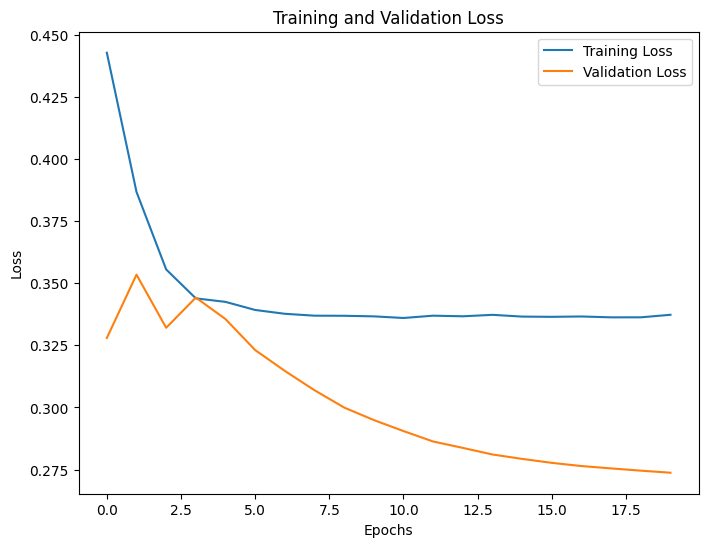

In [31]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_with_validation(model, train_dataloader, val_dataloader, optimizer, criterion, EPOCHS, DEVICE)

Epoch [1/35], Training Loss: 0.3386, Validation Loss: 0.2894
Epoch [2/35], Training Loss: 0.3353, Validation Loss: 0.2441
Epoch [3/35], Training Loss: 0.3304, Validation Loss: 0.2176
Epoch [4/35], Training Loss: 0.3295, Validation Loss: 0.2128
Epoch [5/35], Training Loss: 0.3285, Validation Loss: 0.2107
Epoch [6/35], Training Loss: 0.3285, Validation Loss: 0.2098
Epoch [7/35], Training Loss: 0.3278, Validation Loss: 0.2109
Epoch [8/35], Training Loss: 0.3275, Validation Loss: 0.2117
Epoch [9/35], Training Loss: 0.3274, Validation Loss: 0.2130
Epoch [10/35], Training Loss: 0.3272, Validation Loss: 0.2151
Epoch [11/35], Training Loss: 0.3272, Validation Loss: 0.2167
Epoch [12/35], Training Loss: 0.3274, Validation Loss: 0.2182
Epoch [13/35], Training Loss: 0.3271, Validation Loss: 0.2196
Epoch [14/35], Training Loss: 0.3267, Validation Loss: 0.2205
Epoch [15/35], Training Loss: 0.3272, Validation Loss: 0.2214
Epoch [16/35], Training Loss: 0.3272, Validation Loss: 0.2222
Epoch [17/35], Tr

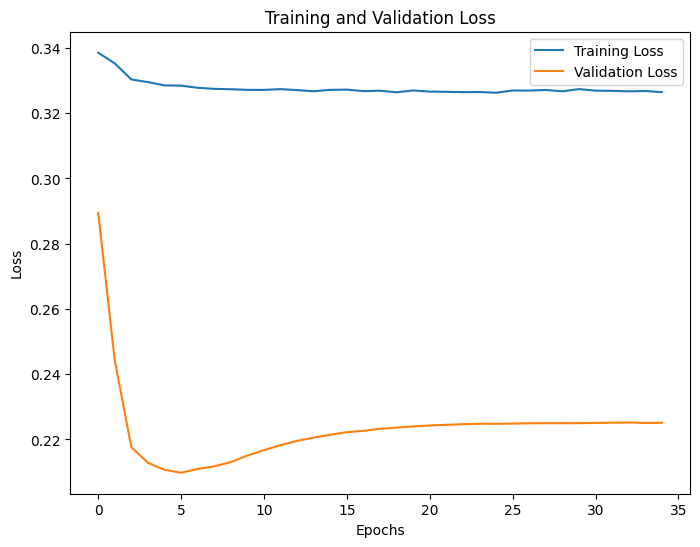

In [32]:
EPOCHS = 35
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_with_validation(model, train_dataloader, val_dataloader, optimizer, criterion, EPOCHS, DEVICE)

Epoch [1/20], Training Loss: 0.3280, Validation Loss: 0.2102
Epoch [2/20], Training Loss: 0.3286, Validation Loss: 0.2111
Epoch [3/20], Training Loss: 0.3274, Validation Loss: 0.2167
Epoch [4/20], Training Loss: 0.3272, Validation Loss: 0.2193
Epoch [5/20], Training Loss: 0.3269, Validation Loss: 0.2188
Epoch [6/20], Training Loss: 0.3264, Validation Loss: 0.2175
Epoch [7/20], Training Loss: 0.3273, Validation Loss: 0.2169
Epoch [8/20], Training Loss: 0.3266, Validation Loss: 0.2187
Epoch [9/20], Training Loss: 0.3267, Validation Loss: 0.2241
Epoch [10/20], Training Loss: 0.3270, Validation Loss: 0.2308
Epoch [11/20], Training Loss: 0.3264, Validation Loss: 0.2345
Epoch [12/20], Training Loss: 0.3271, Validation Loss: 0.2316
Epoch [13/20], Training Loss: 0.3266, Validation Loss: 0.2283
Epoch [14/20], Training Loss: 0.3266, Validation Loss: 0.2281
Epoch [15/20], Training Loss: 0.3266, Validation Loss: 0.2308
Epoch [16/20], Training Loss: 0.3263, Validation Loss: 0.2335
Epoch [17/20], Tr

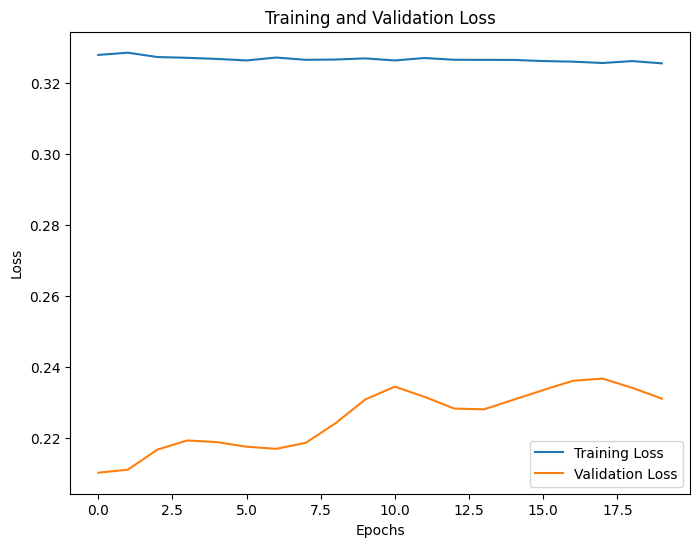

In [23]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_with_validation(model, train_dataloader, val_dataloader, optimizer, criterion, EPOCHS, DEVICE)